In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import collections

import warnings
warnings.filterwarnings('ignore')

#from ecotools.pi_client import pi_client
from ecotools.pi_client import pi_client

pi = pi_client(root='readonly')

In [2]:
# Single String
tags = pi.search_by_point(['*gbsf*kbtu*'])

print("Number of tags: {}".format(len(tags)))
tags

Number of tags: 3


['GBSF_ChilledWater_Demand_kBtu',
 'GBSF_Electricity_Demand_kBtu',
 'GBSF_Steam_Demand_kBtu']

In [3]:
tags2 = ['GBSF_Electricity_Demand_kBtu',
        'aiTIT4045']

In [4]:
# Required parameters
start = '*-2y'  # Date format YYYY-MM-DD (HH:MM:SS optional)
end = '*'    # Date format YYYY-MM-DD (HH:MM:SS optional)
calc = 'summary' # interpolated, recorded, summary
#calc = 'interpolated' # interpolated, recorded, summary
#calc = 'recorded' # interpolated, recorded, summary
interval = '15m'       # m, h, d...

# Extras
chunk_size = 20
weight = 'TimeWeighted'
summary_calc = 'Coming soon!'
max_count = round(1500000/len(tags))

df = pi.get_stream_by_point(tags2, start=start, end=end, calculation=calc, interval=interval, _weight=weight, _max_count=max_count, _chunk_size=chunk_size)

df.head()

Grabbing WebIDs ...
WebID collection complete!
09:18:25: Sending API request... Chunk 1 of 1
09:18:38: Response recieved for 2 tags! (13.39)


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2017-07-10 09:18:25.375934500,3137.950821,77.852232
2017-07-10 09:33:25.375934500,3125.735815,78.961230
2017-07-10 09:48:25.375934500,3225.422427,80.242114
2017-07-10 10:03:25.375934500,3229.816427,80.912659
2017-07-10 10:18:25.375934500,3281.863030,81.955645


In [5]:
df.isna().sum()

GBSF_Electricity_Demand_kBtu    109
aiTIT4045                       464
dtype: int64

In [6]:
df = df.reset_index()
df = df.set_index(pd.to_datetime(df['Timestamp']), drop=True)
#ts = df.iloc[:,0].dropna()
df.dtypes

Timestamp                       datetime64[ns]
GBSF_Electricity_Demand_kBtu           float64
aiTIT4045                              float64
dtype: object

# Clean data to reference

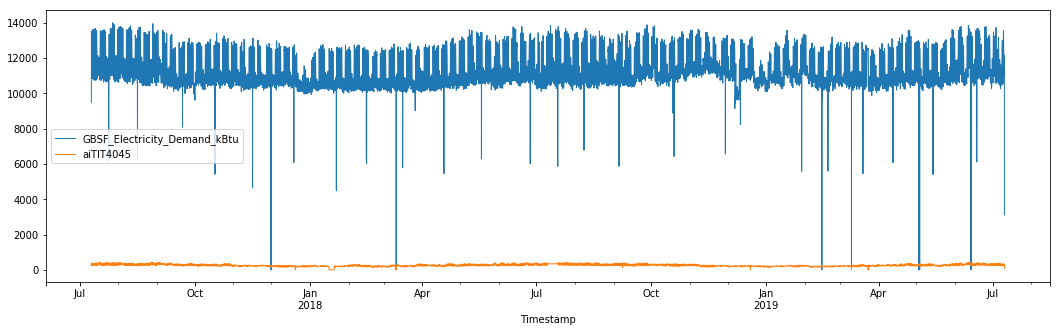

In [7]:
df_hour = df.resample('1h').sum()
df_hour.plot(figsize=(18,5), linewidth=1)

In [8]:
from matplotlib import style
style.use('fivethirtyeight')

df_hour = df.resample('1h').sum()
df_clean = df_hour.loc[:,'GBSF_Electricity_Demand_kBtu'][0:int(len(df_hour.GBSF_Electricity_Demand_kBtu)/2)]

df_clean = df_clean.drop(df_clean[df_clean.values<10000].index, axis=0)

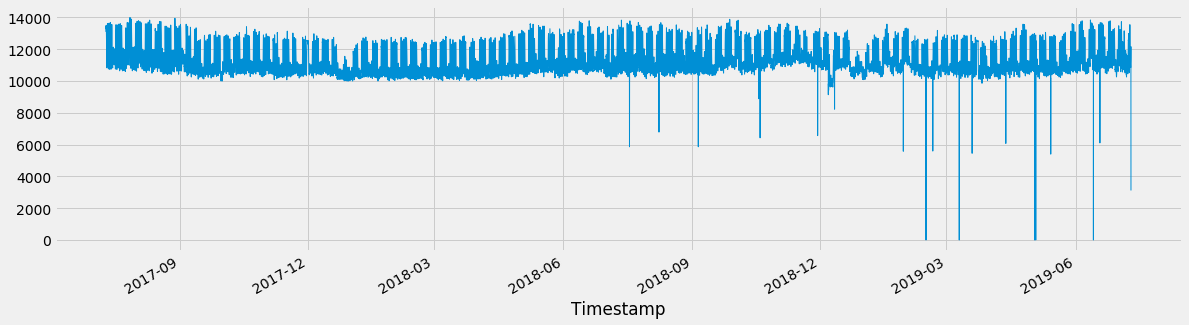

In [9]:
df_merge = pd.concat([df_clean, df_hour.loc[:,'GBSF_Electricity_Demand_kBtu'][int(len(df_hour.GBSF_Electricity_Demand_kBtu)/2):]], axis=0)
df_merge.sort_index(ascending=True)
df_merge.plot(figsize=(18,5), linewidth=1)

## Seasonal decomposition

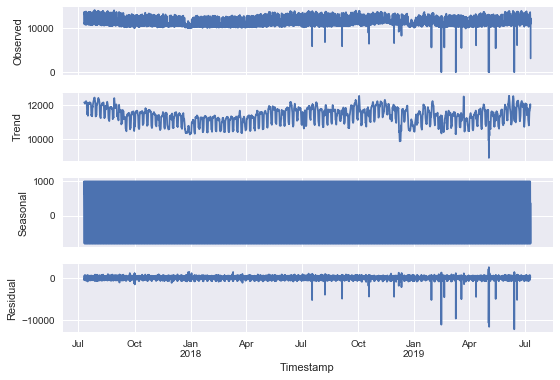

<Figure size 1296x360 with 0 Axes>

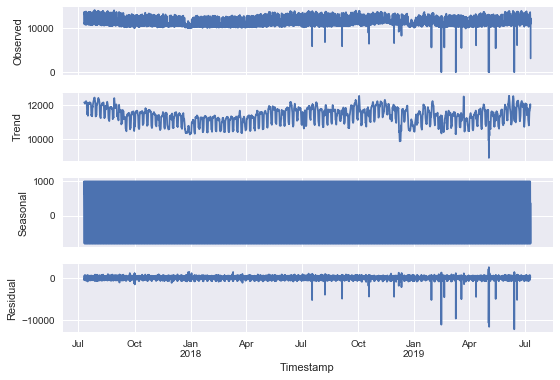

In [10]:
import statsmodels.api as sm
from matplotlib import style
style.use('seaborn')

plt.figure(figsize=(18,5))
#ts = df['GBSF_Electricity_Demand_kBtu'].resample('H').sum()
ts = df_merge.asfreq('1h', fill_value=df_merge.median())
decompos = sm.tsa.seasonal_decompose(ts, model='additive')
decompos.plot()

In [25]:
iqr = decompos.resid.quantile(0.75) - decompos.resid.quantile(0.25)
q75 = decompos.resid.quantile(0.75)
q25 = decompos.resid.quantile(0.25)
upper = q75 + iqr*3
lower = q25 - iqr*3

mad = np.median(abs((decompos.resid - decompos.resid.median()).dropna()))
b = 1.4826
sig = b * mad
sig3 = sig * 3

#upper = sig*3
#lower = sig*3

print(upper)
print(lower)
#print(mad)
print(sig3)

1642.3240920849892
-1615.3648911089554
1036.7986694646186


In [12]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import sesd
#ts = df.iloc[:,0].dropna()

outliers_indices = sesd.seasonal_esd(ts, seasonality=None, hybrid=True,
                                     max_anomalies=int(len(ts)*0.05),
                                    alpha=0.05)
for idx in outliers_indices:
    print("Anomaly index: {0}, anomaly value: {1}".format(idx, ts[idx]))

Anomaly index: 16877, anomaly value: 0.0
Anomaly index: 15892, anomaly value: 0.0
Anomaly index: 15871, anomaly value: 0.0
Anomaly index: 15873, anomaly value: 0.0
Anomaly index: 14016, anomaly value: 0.0
Anomaly index: 15874, anomaly value: 2810.8845109115914
Anomaly index: 14584, anomaly value: 0.0
Anomaly index: 14015, anomaly value: 2678.9783988017484
Anomaly index: 17519, anomaly value: 3115.0502606753334
Anomaly index: 16878, anomaly value: 6622.760044623303
Anomaly index: 16148, anomaly value: 5402.95381071379
Anomaly index: 15872, anomaly value: 5947.9200563483255
Anomaly index: 15893, anomaly value: 6357.932663306678
Anomaly index: 15891, anomaly value: 6461.915568732077
Anomaly index: 16988, anomaly value: 6107.710571700624
Anomaly index: 0, anomaly value: 13093.952938422713
Anomaly index: 10512, anomaly value: 12785.298909957492
Anomaly index: 14132, anomaly value: 5595.499294421194
Anomaly index: 14804, anomaly value: 5453.798686624041
Anomaly index: 15380, anomaly value: 6

<function matplotlib.pyplot.show(*args, **kw)>

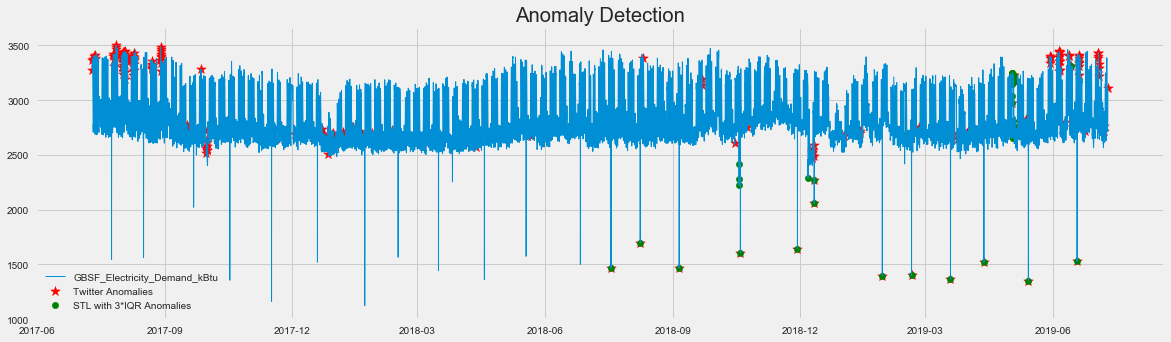

In [77]:
from matplotlib import style
style.use('fivethirtyeight')

ts_og = df.GBSF_Electricity_Demand_kBtu.resample("1h").mean()[1:]

plt.figure(figsize=(18,5))
plt.plot(ts_og.index,ts_og, linewidth=1)
plt.scatter(ts_og[outliers_indices].index, ts_og[outliers_indices], color='red',
           marker="*", s=100)
plt.scatter(ts_og[(decompos.resid > upper) | (decompos.resid < lower)].index, ts_og[(decompos.resid > upper) | (decompos.resid < lower)],
           marker="o", color='green', s=40)
plt.legend([df.columns[1],"Twitter Anomalies", "STL with 3*IQR Anomalies"])
plt.title("Anomaly Detection")
plt.show

Text(0.5,1,'Data with Anomalies Removed\nSTL with IQR')

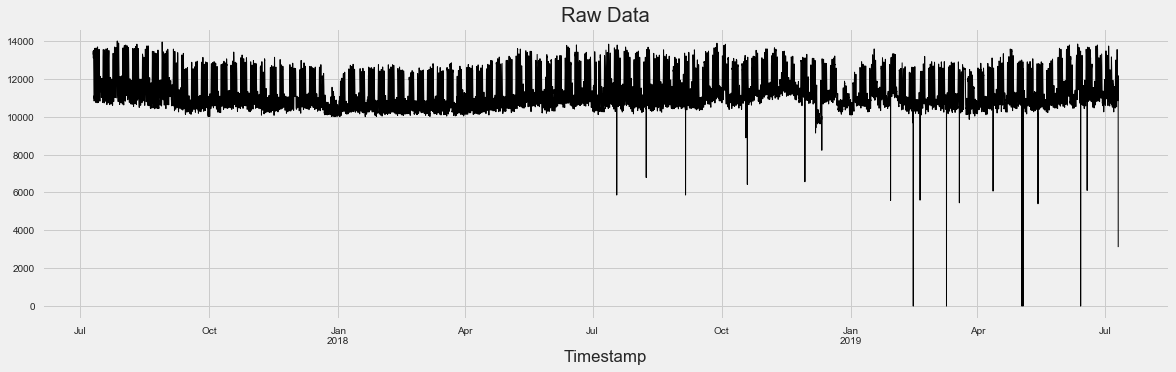

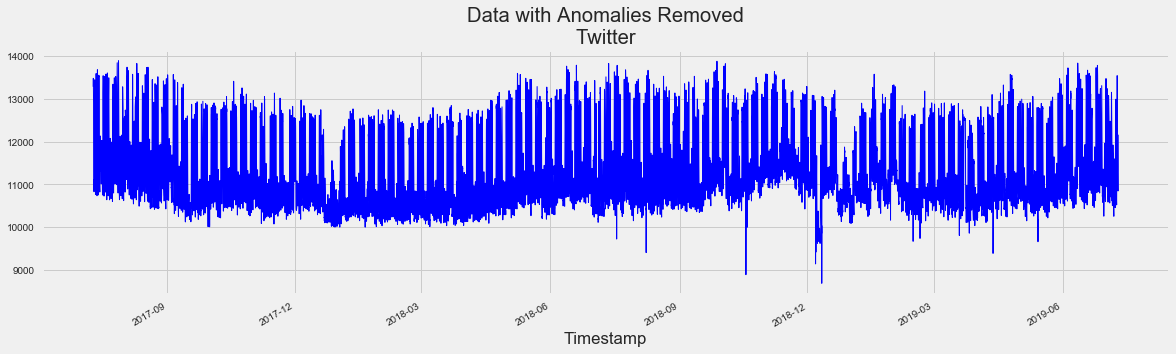

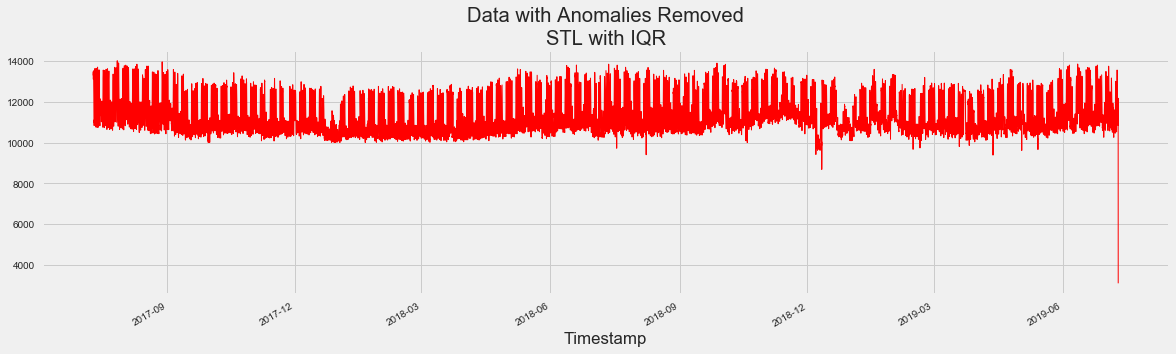

In [28]:
ts2 = ts.drop(ts[outliers_indices].index, axis=0)
ts3 = ts.drop(ts[(decompos.resid > upper) | (decompos.resid < lower)].index, axis=0)
plt.figure(figsize=(18,5))
ts.plot(linewidth=1, color='black')
plt.title("Raw Data")

plt.figure(figsize=(18,5))
ts2.plot(linewidth=1, color='blue')
plt.title("Data with Anomalies Removed\nTwitter")

plt.figure(figsize=(18,5))
ts3.plot(linewidth=1, color='red')
#plt.ylim(8000,14000)
plt.title("Data with Anomalies Removed\nSTL with IQR")

# Model Residual with Machine Learning

## Add variables

In [15]:
mydata = pd.DataFrame({"Resid":decompos.resid,
                    "OAT":df.aiTIT4045.resample("1h").mean()}, index=df.aiTIT4045.resample("1h").mean().index)

mydata.head()

,Resid,OAT
Timestamp,,
2017-07-10 09:00:00,NaN,79.018525
2017-07-10 10:00:00,NaN,82.502623
2017-07-10 11:00:00,NaN,87.261503
2017-07-10 12:00:00,NaN,90.399567
2017-07-10 13:00:00,NaN,93.185357


In [16]:
def add_variables(mydata, y=None):
    mydata["cdd"] = mydata.OAT - 65.0
    mydata.loc[mydata.cdd < 0, "cdd"] = 0
    mydata["hdd"] = 65.0 - mydata.OAT
    mydata.loc[mydata.hdd < 0, "hdd"] = 0

    mydata["cdd2"] = mydata.cdd**2
    mydata["hdd2"] = mydata.hdd**2

    #data["OAT2"] = data.OAT**2

    #data["Date"] = data.index.date

    mydata2 = mydata.copy()

    mydata2["MONTH"]= mydata2.index.month
    mydata2["MONTH"] = mydata2["MONTH"].astype('category')
    mydata2["TOD"] = mydata2.index.hour
    mydata2["TOD"] = mydata2["TOD"].astype('category')
    mydata2["DOW"] = mydata2.index.weekday
    mydata2["DOW"] = mydata2["DOW"].astype('category')

    ### Create dummy variables
    l3 = ["MONTH","TOD","DOW"]#,"WEEK"]#,"DOY"]
    mydata2 = pd.get_dummies(data=mydata2, columns=l3, drop_first=True)

    ### Create Weekend flag
    WEEKEND= [0] * len(mydata2.DOW_5)
    for i in range(0,len(mydata2.DOW_5)):
        if ((mydata2.DOW_5.iloc[i] == 1) | (mydata2.DOW_6.iloc[i] == 1)): 
            WEEKEND[i] = 1 
    else: 0

    mydata2["WEEKEND"] = pd.Series(WEEKEND).values

    mydata2["shift1"] = mydata2[y].shift(1)
    #data2["shift2"] = data2.y.shift(2)
    #data2["shift3"] = data2.y.shift(3)
    #data2["shift4"] = data2.y.shift(4)
    #data2["shift5"] = data2.y.shift(5)

    mydata2["rolling24_mean"] = mydata2[y].rolling('24h').mean()
    mydata2["rolling24_max"] = mydata2[y].rolling('24h').max()
    mydata2["rolling24_min"] = mydata2[y].rolling('24h').min()

    mydata2[mydata2[y].isna()] = 0
    mydata2[mydata2.isna()] = 0
    #mydata2.dropna(inplace=True)
    mydata2.drop(columns='OAT', inplace=True)
    return mydata2[1:]

In [17]:
import math
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
cv = 2

def model(X, y, estimator=None, param_grid=None, scale=False, input_shape=None, random_state=42):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False, random_state=42) 
    
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    X_train_sc = scaler_x.fit_transform(X_train)
    X_test_sc = scaler_x.transform(X_test)
    y_train_sc = scaler_y.fit_transform(np.array(y_train).reshape(-1,1))
    y_test_sc = scaler_y.transform(np.array(y_test).reshape(-1,1))
    
    X_train_sc_3d = np.reshape(np.array(X_train_sc), (np.array(X_train_sc).shape[0], 1, np.array(X_train_sc).shape[1]))
    X_test_sc_3d = np.reshape(np.array(X_test_sc), (np.array(X_test_sc).shape[0], 1, np.array(X_test_sc).shape[1]))
    
    ts_split = TimeSeriesSplit(n_splits=cv).get_n_splits([X_train,y_train])
    
    if  (scale == True) & (input_shape == '3d'):
        X_train, X_test = X_train_sc_3d, X_test_sc_3d
        y_train, y_test = y_train_sc, y_test_sc
        #y_train, y_test = np.reshape(scaler_y.fit_transform(np.reshape(np.array(y_train),(-1,1))),(-1,)), np.reshape(scaler_y.fit_transform(np.reshape(np.array(y_test),(-1,1))),(-1,))
    elif (input_shape != '3d') & (scale == True):
        X_train, X_test = X_train_sc, X_test_sc
    else:
        X_train, X_test = X_train, X_test
    
    try:
        mod = GridSearchCV(estimator, param_grid=param_grid, cv=ts_split).fit(X_train,y_train)
    except: 
        mod = estimator.fit(X_train, y_train)
    
    r2_train = r2_score(y_train, mod.predict(X_train))
    print(f"R2 of training = {round(r2_train,3)}")
    r2_test = r2_score(y_test, mod.predict(X_test))
    print(f"R2 of validation = {round(r2_test,3)}")
    print()
    rmse_train = math.sqrt(mean_squared_error(y_train, mod.predict(X_train)))
    print(f"RMSE of training = {round(rmse_train,3)}")
    rmse_test = math.sqrt(mean_squared_error(y_test, mod.predict(X_test)))
    print(f"RMSE of validation = {round(rmse_test,3)}")
    print()
    mae_train = np.median((mod.predict(X_train) - y_train))
    print(f"MAE of training = {round(mae_train,3)}")
    mae_test = np.median((mod.predict(X_test) - y_test))
    print(f"MAE of validation = {round(mae_test,3)}")
    
    return mod, X_train, X_test, y_train, y_test, scaler_x, scaler_y

In [18]:
from matplotlib import style
style.use('fivethirtyeight')

def mod_plot(mod, X_train=None, X_test=None, y_train=None, y_test=None):
    plt.figure(figsize=(18,2))
    plt.plot(y_train.index, y_train, linewidth=1, color='green')
    plt.plot(y_test.index, y_test, color='lightgreen', linewidth=1)
    plt.title("Training and Validation Split")
    plt.legend(['Training','Test'])
    
    plt.figure()
    training_comparison = pd.DataFrame({"Actual":y_train,
                                       "Modeled":mod.predict(X_train)}, index=y_train.index)
    training_comparison.sort_index().plot(figsize=(18,3),
                             title="Training Data vs Model Prediction",
                             linewidth=1,
                             color=['black','gray'])
    
    plt.figure()
    test_comparison = pd.DataFrame({"Actual":y_test,
                                       "Modeled":mod.predict(X_test)}, index=y_test.index)
    test_comparison.sort_index().plot(figsize=(18,3),
                         title="Validation Data vs Model Prediction",
                         linewidth=1,
                         colormap='winter')

R2 of training = 0.909
R2 of validation = 0.43

RMSE of training = 100.532
RMSE of validation = 384.652

MAE of training = 2.001
MAE of validation = 2.754


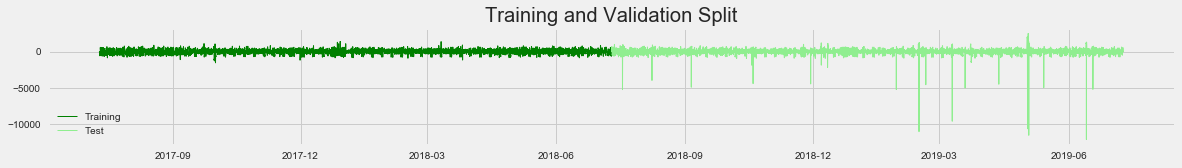

<Figure size 576x396 with 0 Axes>

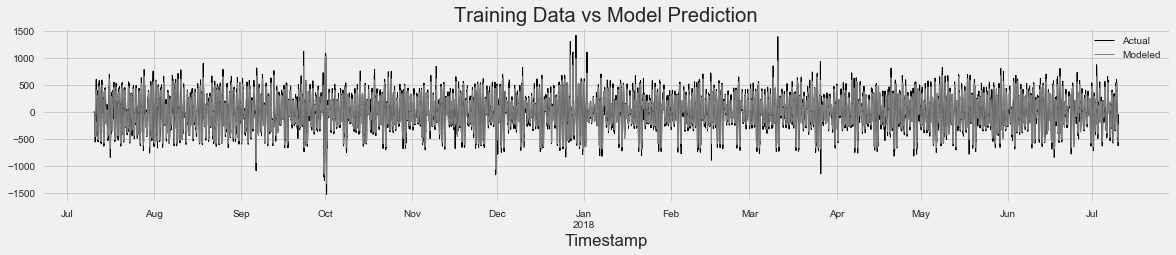

<Figure size 576x396 with 0 Axes>

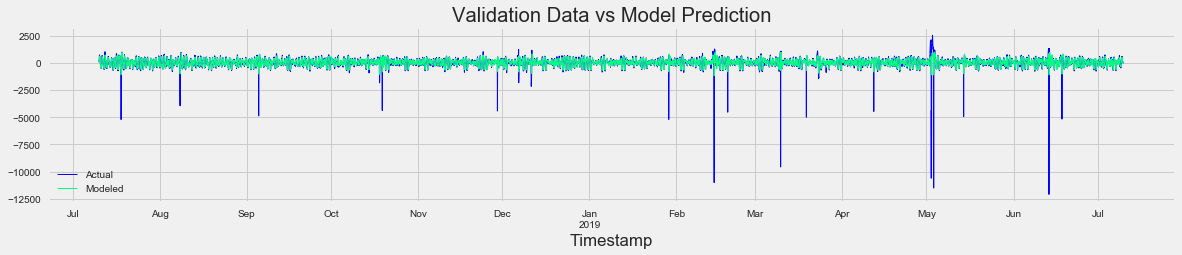

In [30]:
from sklearn.ensemble import RandomForestRegressor
mydata2 = add_variables(mydata, y='Resid')

y = mydata2.Resid
X = mydata2.drop(columns=['Resid'])
#X = data_short.loc[:, best_columns]

estimator = RandomForestRegressor(random_state=42, n_jobs=-1)

params_rf = {'n_estimators':[100,1000], 'max_depth':[2, 10]}

rf, X_train, X_test, y_train, y_test, scaler_x, scaler_y = model(X, y, estimator=estimator, param_grid=params_rf, scale=False)

mod_plot(rf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [59]:
d = df.GBSF_Electricity_Demand_kBtu[1:].resample('1h').sum().asfreq('1h', fill_value=df_merge.median())
d[d.isna()] = 0

res = sm.tsa.seasonal_decompose(d, model='additive')

og = pd.DataFrame({"Resid":res.resid,
                    "OAT":df.aiTIT4045.resample("1h").mean()}, index=df.aiTIT4045.resample("1h").mean().index)

preds = rf.predict(add_variables(og, y='Resid').drop(columns=['Resid']))

compare = pd.DataFrame({"Residuals":og.Resid[1:],
                      "Pred":preds,
                       "Actual":og.Resid[1:] + res.seasonal[1:] + res.trend[1:]})
#compare = pd.DataFrame({"Actual":og.Resid[1:] + res.seasonal[1:] + res.trend[1:],
#                      "Pred":preds + res.seasonal[1:] + res.trend[1:]})
                        
compare['Diff'] = compare.Residuals - compare.Pred
#compare.plot(figsize=(18,5), linewidth=1, secondary_y='Diff')

<function matplotlib.pyplot.show(*args, **kw)>

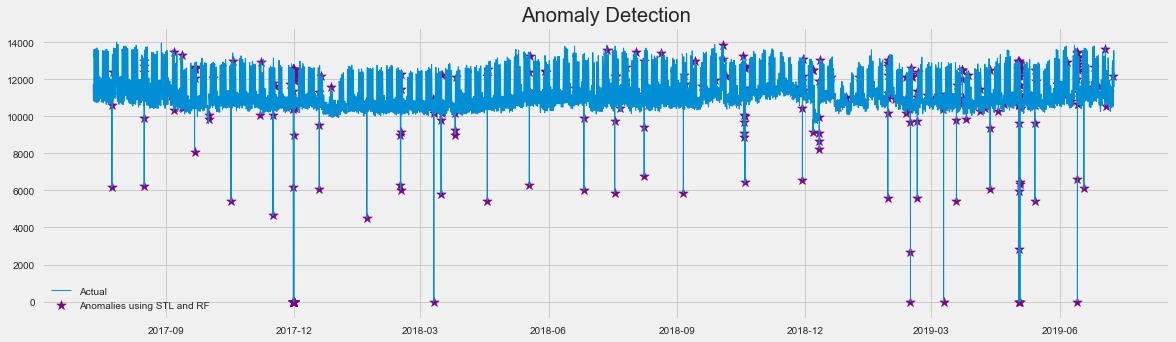

In [79]:
from matplotlib import style
style.use('fivethirtyeight')

compare_whole = compare

plt.figure(figsize=(18,5))
plt.plot(compare.index, compare.Actual, linewidth=1)
plt.scatter(compare.loc[compare.Diff > compare.Diff.quantile(0.99), "Actual"].index, compare.loc[compare.Diff > compare.Diff.quantile(0.99), "Actual"], 
            color='purple', marker="*", s=100)
plt.scatter(compare.loc[compare.Diff < compare.Diff.quantile(0.01), "Actual"].index, compare.loc[compare.Diff < compare.Diff.quantile(0.01), "Actual"], 
            color='purple', marker="*", s=100)
plt.legend(["Actual","Anomalies using STL and RF"])
plt.title("Anomaly Detection")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

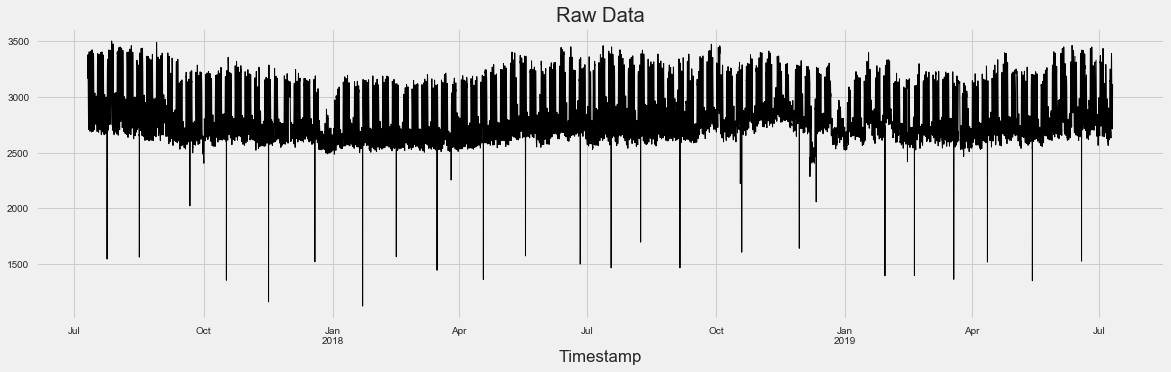

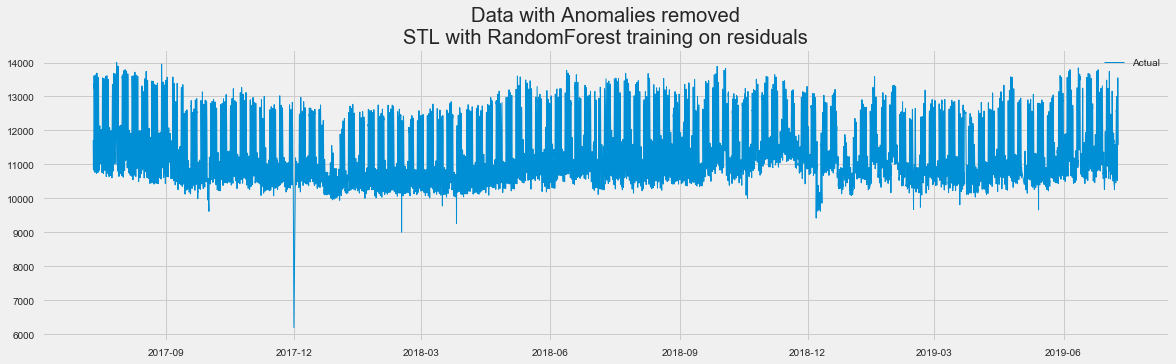

In [68]:
from matplotlib import style
style.use('fivethirtyeight')

compare_cut = compare.loc[(compare.Residuals < compare.Residuals.quantile(0.99)) & 
                         (compare.Residuals > compare.Residuals.quantile(0.01)), "Actual"]

plt.figure(figsize=(18,5))
df.GBSF_Electricity_Demand_kBtu.resample("1h").mean().plot(linewidth=1, color='black')
plt.title("Raw Data")

plt.figure(figsize=(18,5))
plt.plot(compare_cut.index, compare_cut, linewidth=1)
plt.legend(["Actual"])
plt.title("Data with Anomalies removed\nSTL with RandomForest training on residuals")
plt.show